In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import requests, gzip
import numpy as np
def get(url):
    return np.frombuffer(gzip.decompress(requests.get(url).content), dtype=np.uint8)

X_train = get("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = get("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = get("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = get("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

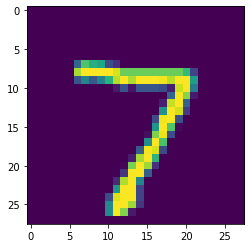

In [4]:
from matplotlib.pyplot import imshow
imshow(X_test[0])

In [ ]:
N_EPOCH = 500
LR = 0.01
BS = 250

In [5]:
import torch
torch.set_printoptions(sci_mode=False)
# Feature Scaling
X_train_scaled = torch.tensor([np.reshape(xi/256, (-1)) for xi in X_train], dtype=torch.float32)
X_test_scaled = torch.tensor([np.reshape(xi/256, (-1, 28*28)) for xi in X_test], dtype=torch.float32)

# One-Hot encoded targets
y_train_one_hot = [[1 if i == l else 0 for i in range(10)] for l in y_train]
y_test_one_hot = [[1 if i == l else 0 for i in range(10)] for l in y_test]

y_train_torch = torch.tensor(y_train.copy())
y_test_torch = torch.tensor(y_test.copy())
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_ds = TensorDataset(X_train_scaled, y_train_torch)
test_ds = TensorDataset(X_test_scaled, y_test_torch)
train_dl = DataLoader(train_ds, BS, shuffle=True)
test_dl = DataLoader(test_ds)

/var/folders/c4/j059kg7n61q9x8b27zrclg8c0000gn/T/ipykernel_23057/2845450077.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  X_train_scaled = torch.tensor([np.reshape(xi/256, (-1)) for xi in X_train], dtype=torch.float32)


In [34]:
import model
model = model.conNet()

In [35]:
import wandb
wandb.init(project="mnist", entity="0xasim")
wandb.config = {
  "learning_rate": LR,
  "epochs": N_EPOCH,
  "batch_size": BS
}

wandb: Currently logged in as: 0xasim. Use `wandb login --relogin` to force relogin


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm
loss_hist = np.zeros(N_EPOCH)
accuracy_hist = np.zeros(N_EPOCH)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
for epoch in tqdm(range(N_EPOCH)):
    for x_batch, y_batch in train_dl:
        # print(pred[0], y_batch[0])
        # imshow((x_batch[0][0]*256).reshape(28,28))
        b_x = Variable(x_batch)
        b_y = Variable(y_batch)
        pred = model.forward(b_x)
        loss = loss_fn(pred, b_y)
        # clear gradients for this training step
        optimizer.zero_grad()
        # backprop, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()
        loss_hist[epoch] += loss.item()*y_batch.size()[0]
    wandb.log({"loss": loss_hist[epoch]})

print(loss_hist)

100%|██████████| 100/100 [00:50<00:00,  2.00it/s]

[1.73497598e+06 2.35318579e+05 1.03195078e+05 5.27176701e+04
 3.70229177e+04 2.90995644e+04 2.46091834e+04 2.10422849e+04
 1.85277442e+04 1.67891912e+04 1.48938705e+04 1.32798563e+04
 1.28840083e+04 1.20717945e+04 1.10849813e+04 1.03564445e+04
 9.83685303e+03 9.30741544e+03 9.30602140e+03 8.84967107e+03
 8.44357046e+03 8.16780597e+03 7.83516730e+03 7.40814877e+03
 6.86582526e+03 6.57182762e+03 6.24659416e+03 6.19149289e+03
 5.22036990e+03 5.80699932e+03 5.40494681e+03 5.10226394e+03
 5.12146138e+03 4.55666171e+03 4.64517451e+03 3.84402203e+03
 4.09918344e+03 5.11461285e+03 3.79440550e+03 3.72374631e+03
 3.20757842e+03 3.84532429e+03 3.84549837e+03 3.47442741e+03
 3.09240612e+03 3.00784208e+03 3.24640461e+03 3.18631207e+03
 3.31262138e+03 3.08472517e+03 3.21629326e+03 2.62381757e+03
 2.61457005e+03 2.68000475e+03 2.88645816e+03 3.10397852e+03
 2.45686741e+03 2.35566002e+03 2.46837976e+03 2.26813789e+03
 2.28270656e+03 2.35578308e+03 2.21911775e+03 1.65248191e+03
 1.56951367e+03 2.503288

In [38]:
with torch.no_grad():
    n_correct = 0
    for x, target in test_dl:
        # b_x = Variable(x)[0]
        b_x = x
        pred = model.forward(b_x)
        top_1 = torch.argmax(pred)
        n_correct += (top_1 == target)
    print(f'accuracy: {n_correct[0]/10_00*100}%')

accuracy: 98.0%
